Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Datos cargados:
  Filas totales: 231,292
  Modelos unicos: 211
  Reacciones unicas: 4,388
  Sitios: 8

Reacciones CON genes (GPR): 231,292 (100.0%)
Reacciones SIN genes: 0 (0.0%)

Modelos por sitio:
  al: 33 modelos
  chon: 39 modelos
  doc: 32 modelos
  ilq: 11 modelos
  nav: 15 modelos
  par: 16 modelos
  sant: 16 modelos
  top: 49 modelos

Reacciones unicas por sitio:
  al: 3,406 reacciones
  chon: 3,612 reacciones
  doc: 3,310 reacciones
  ilq: 2,696 reacciones
  nav: 2,779 reacciones
  par: 2,935 reacciones
  sant: 3,065 reacciones
  top: 3,408 reacciones

CARGA DE NOMBRES DESDE PADMET Y CSV

Subsistemas cargados desde PADMET: 3008

Ejemplos de subsistemas cargados:
  PWY-1                -> L-asparagine Biosynthesis...
  PWYLSPIAHJFU-YKRRISCLSA-O -> amicoumacin B INCHI-KEY InChIKey=LOXFXXGTOVWWQV-YKRRISCLSA-N...
  PWYNONCSGZEQQ-ICSRJNTNSA-N -> L-&beta;

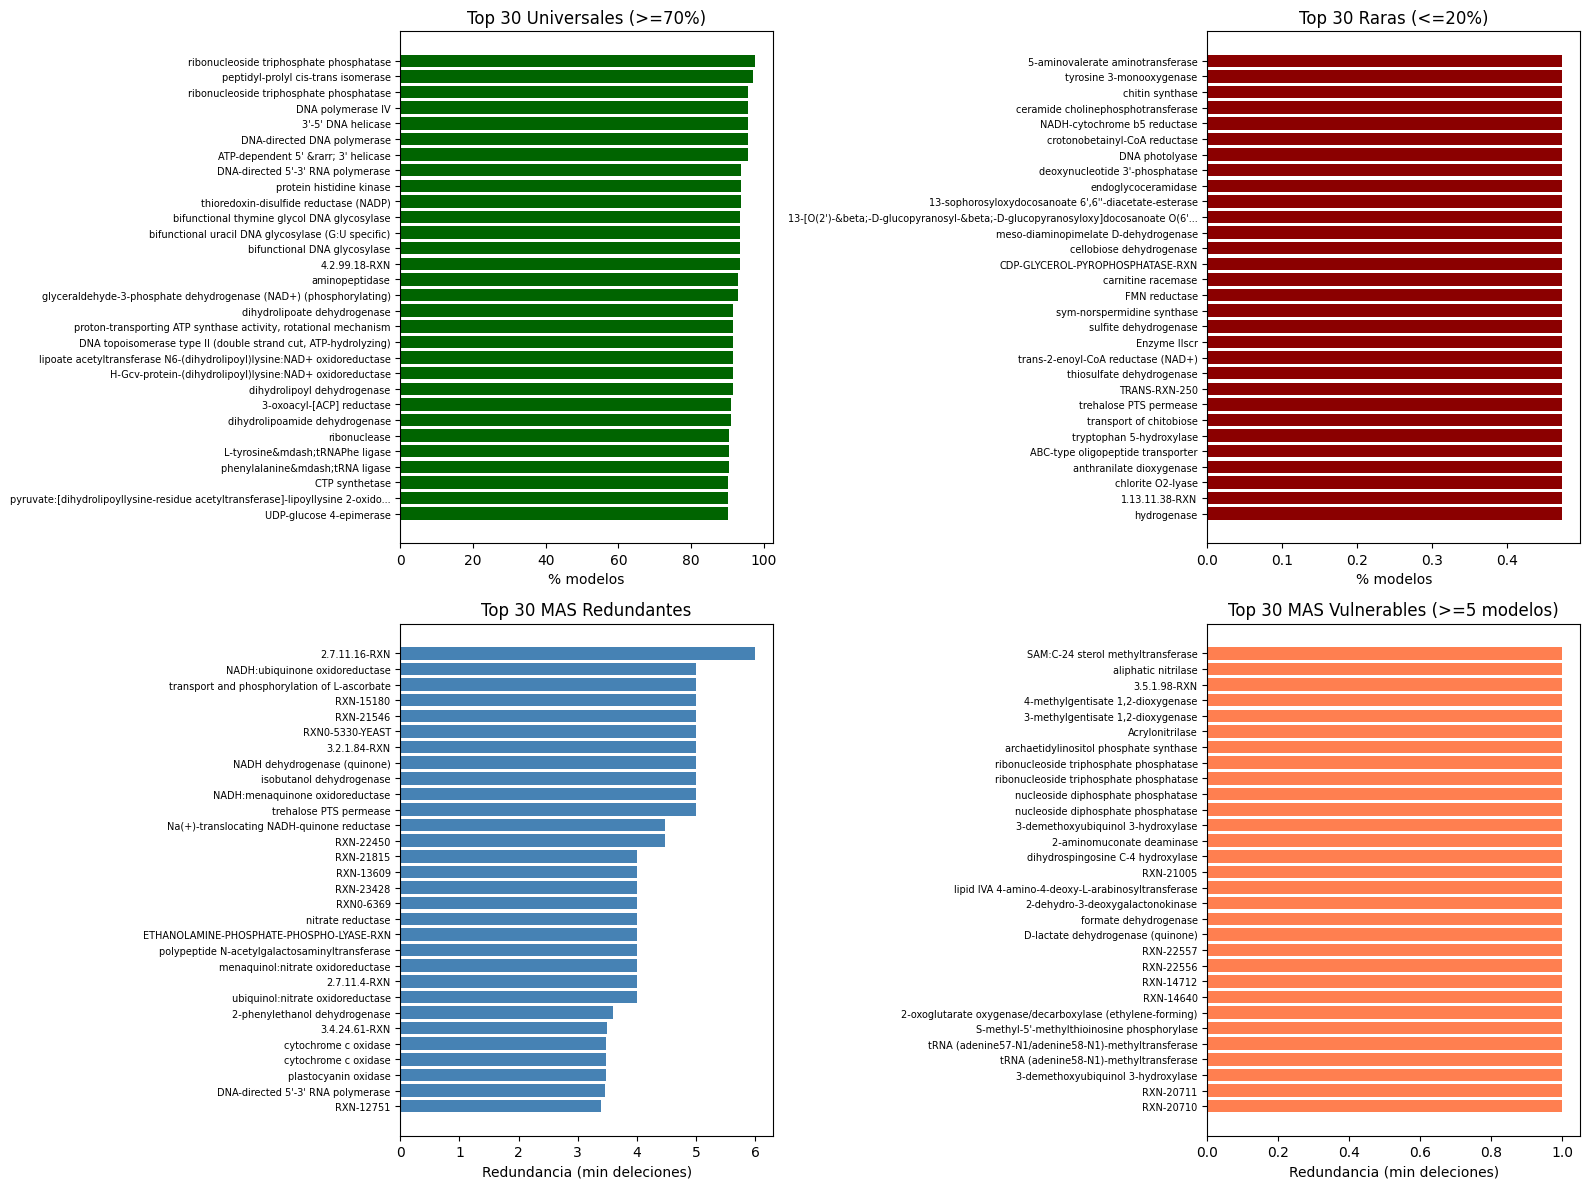

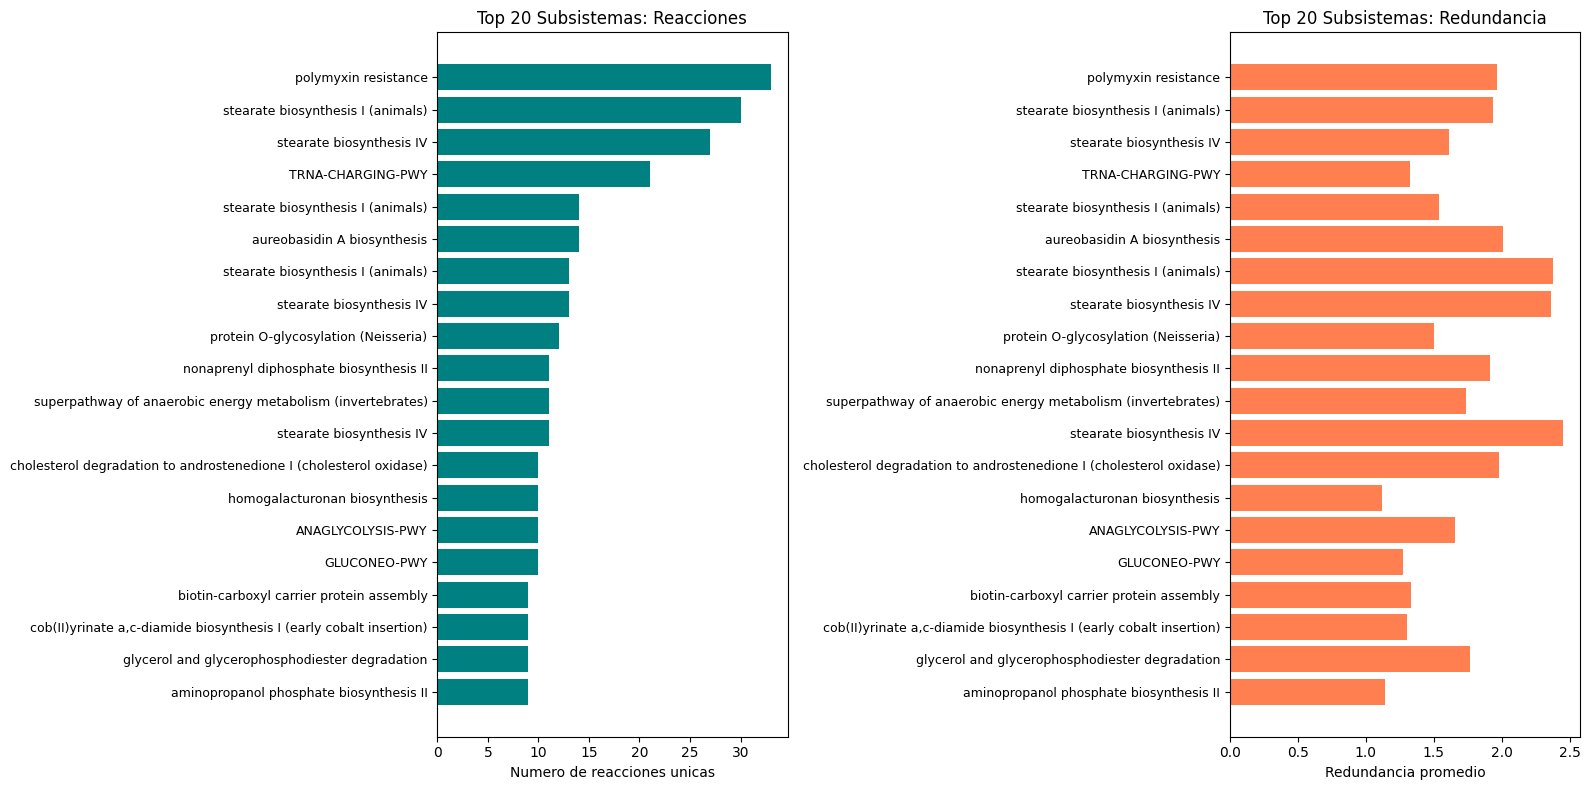

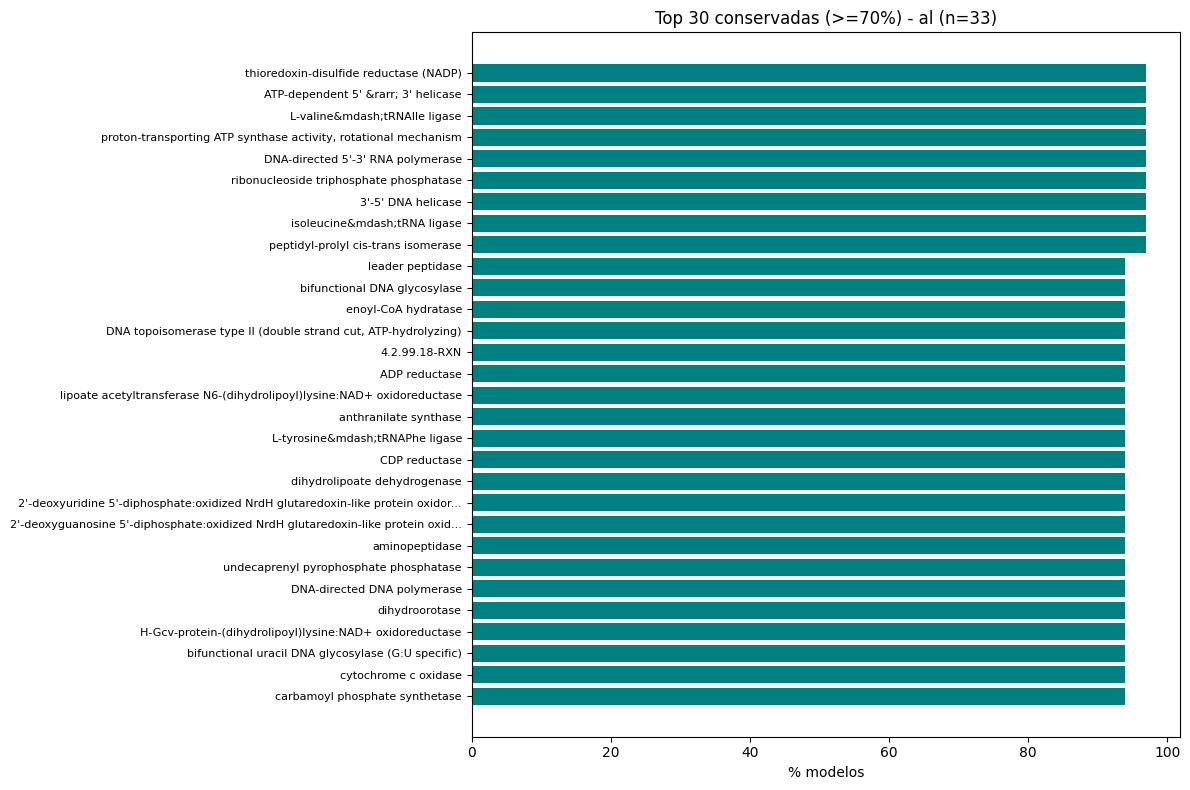

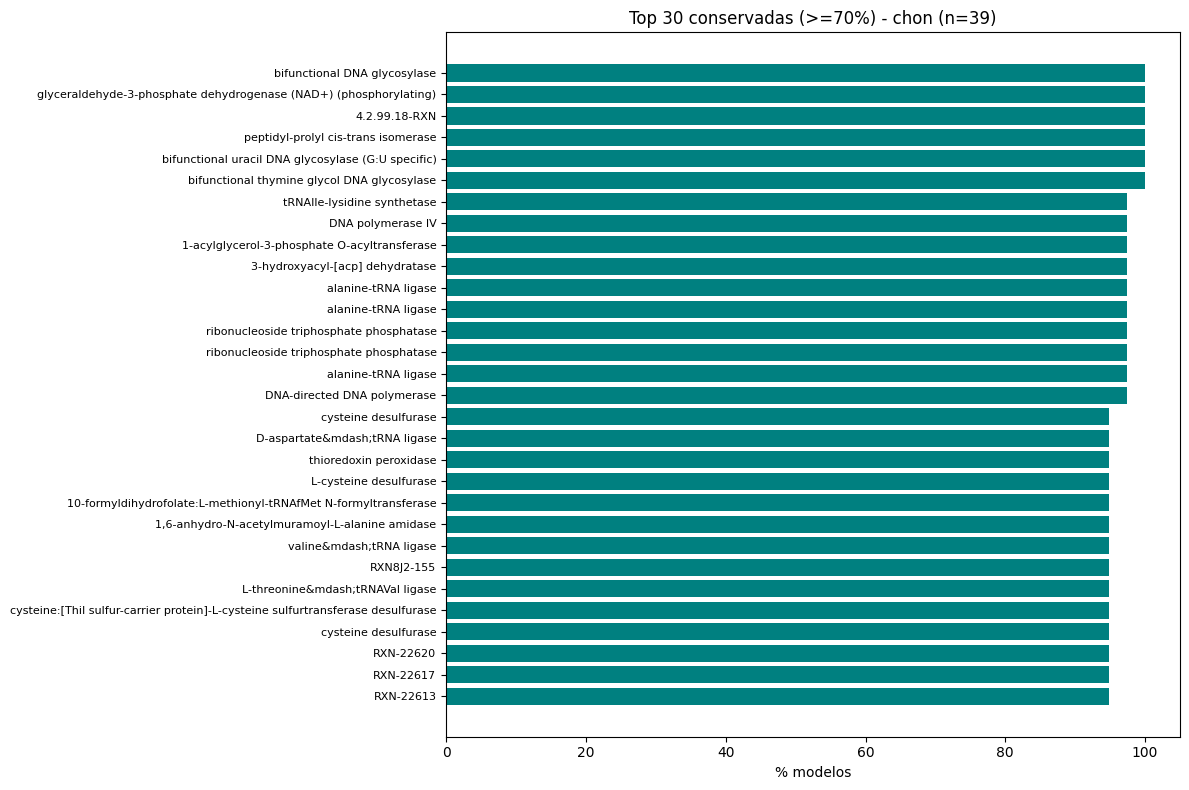

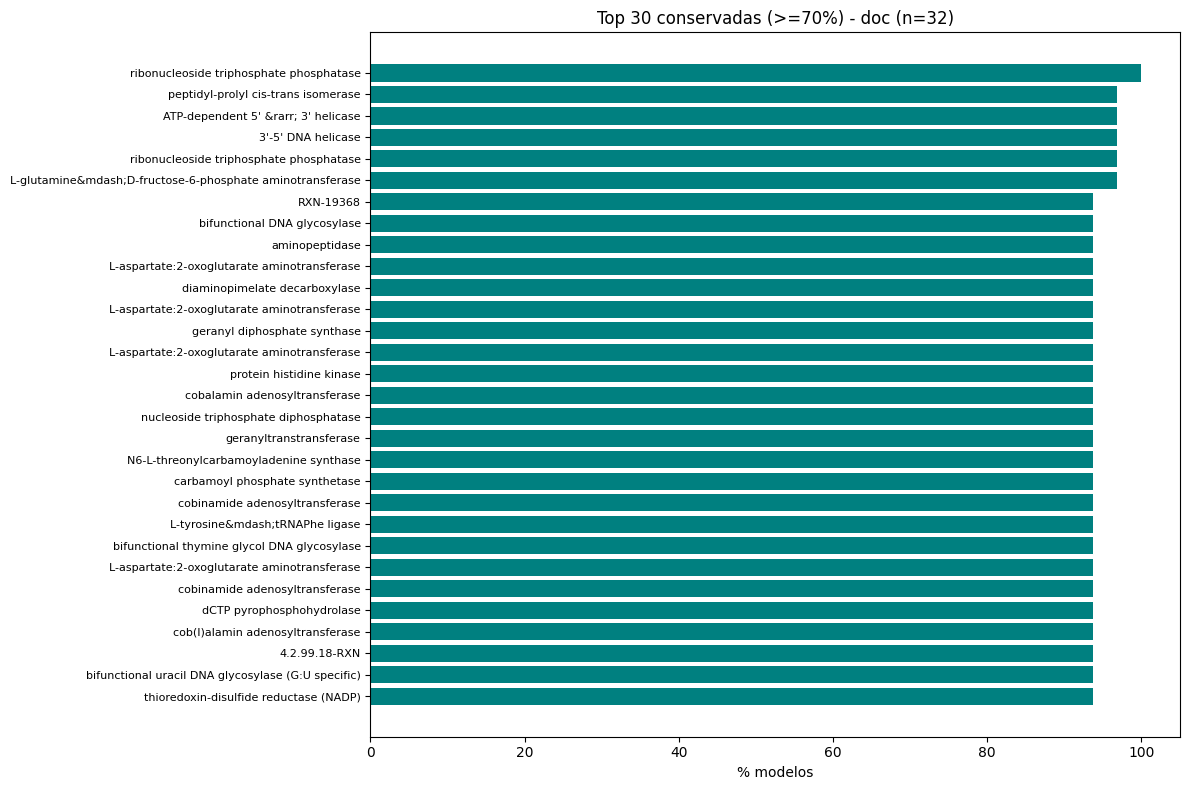

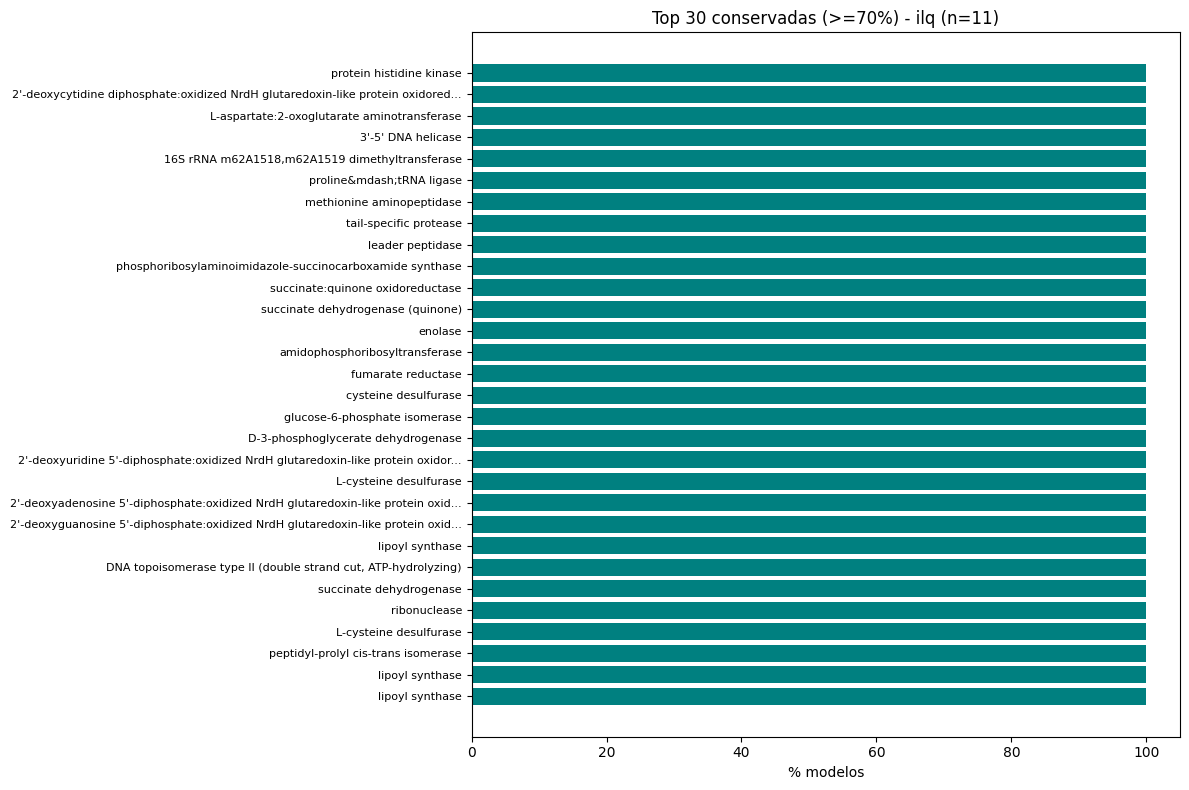

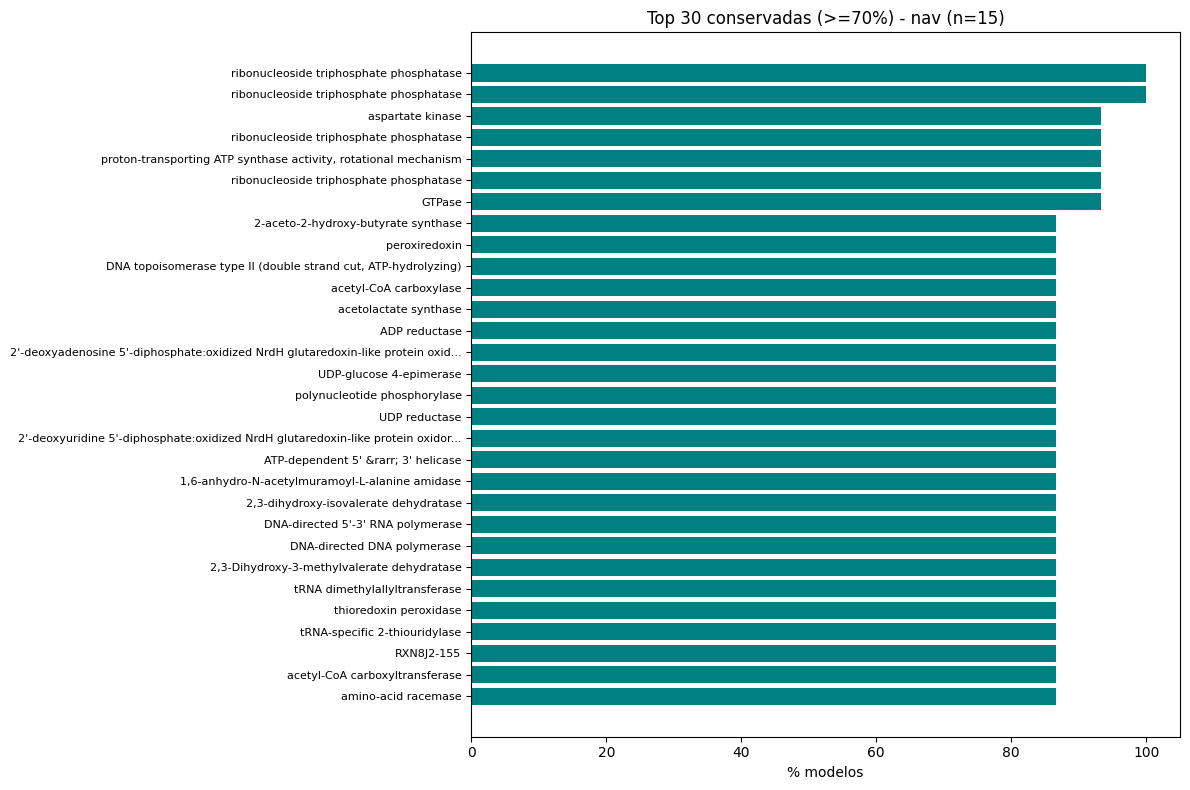

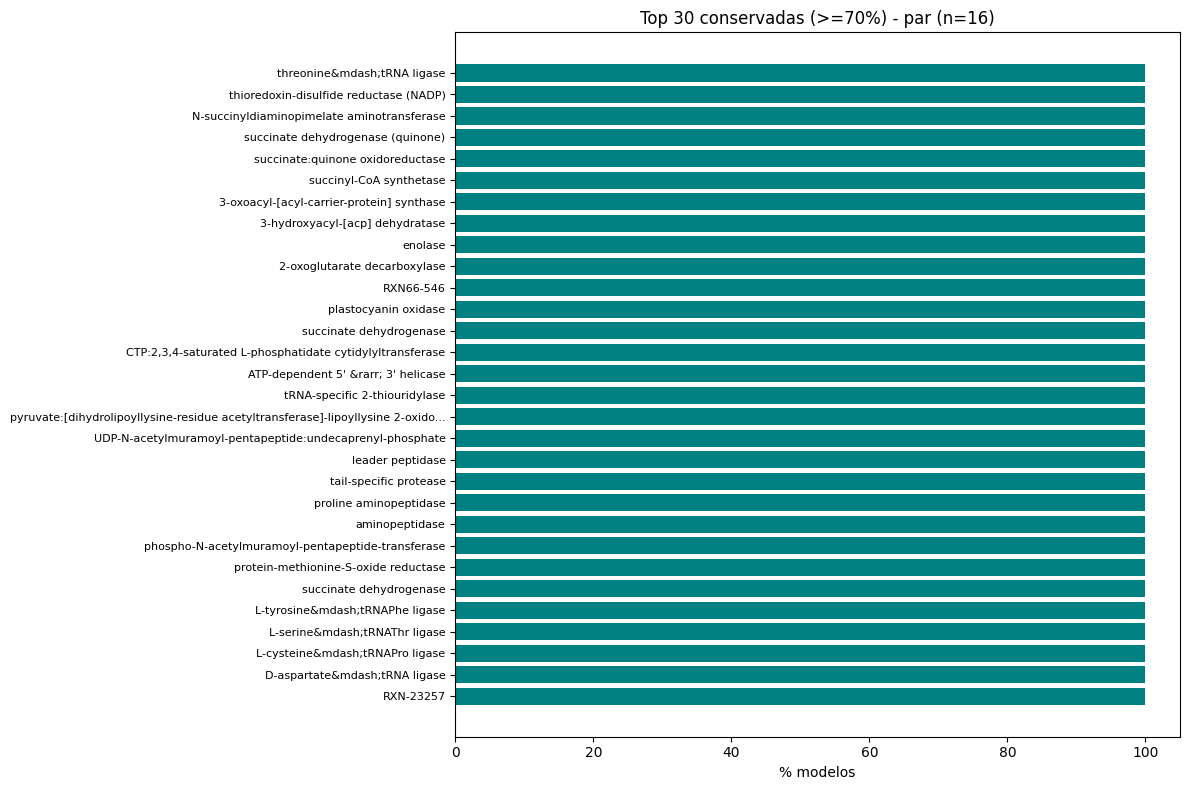

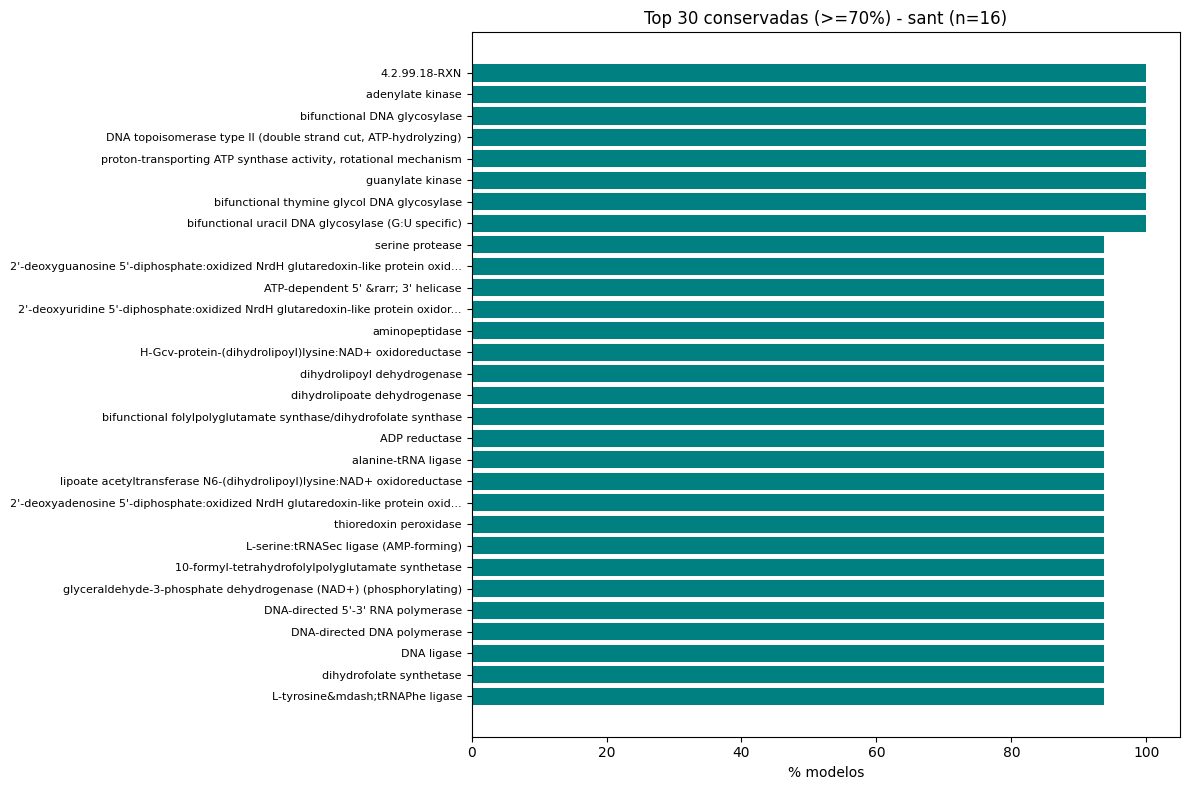

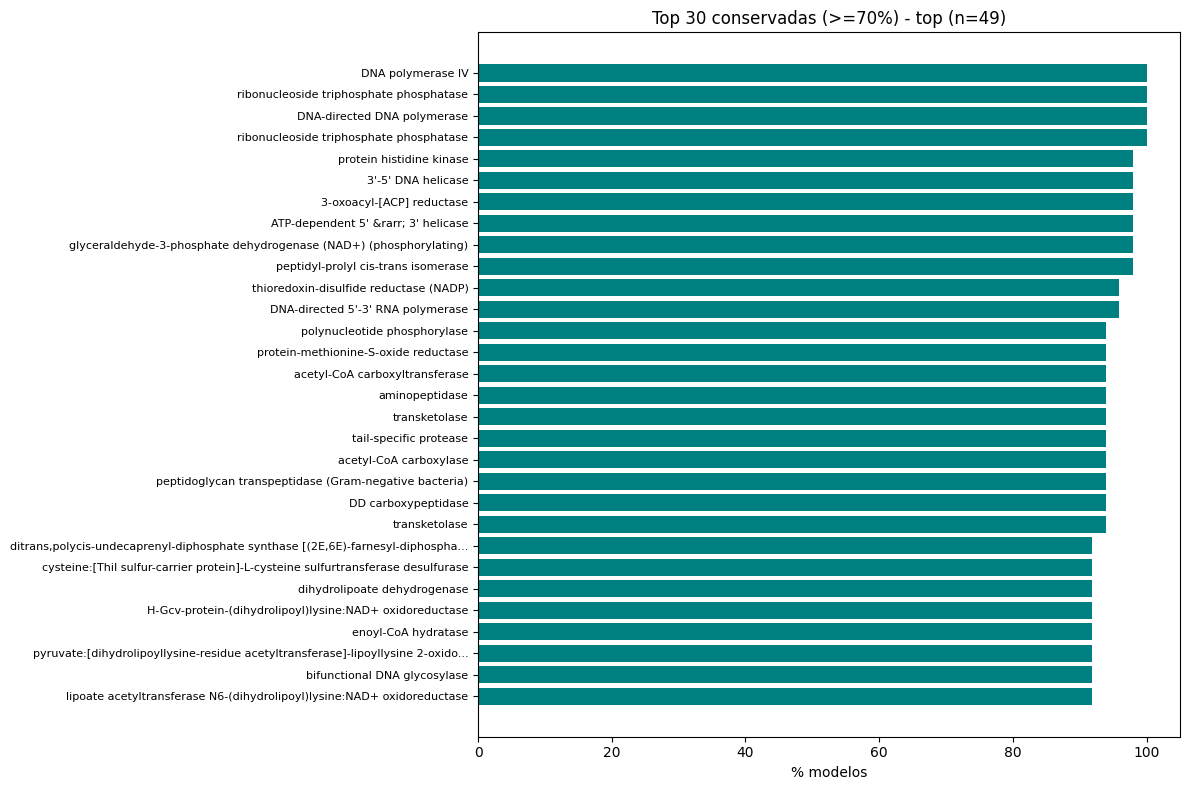

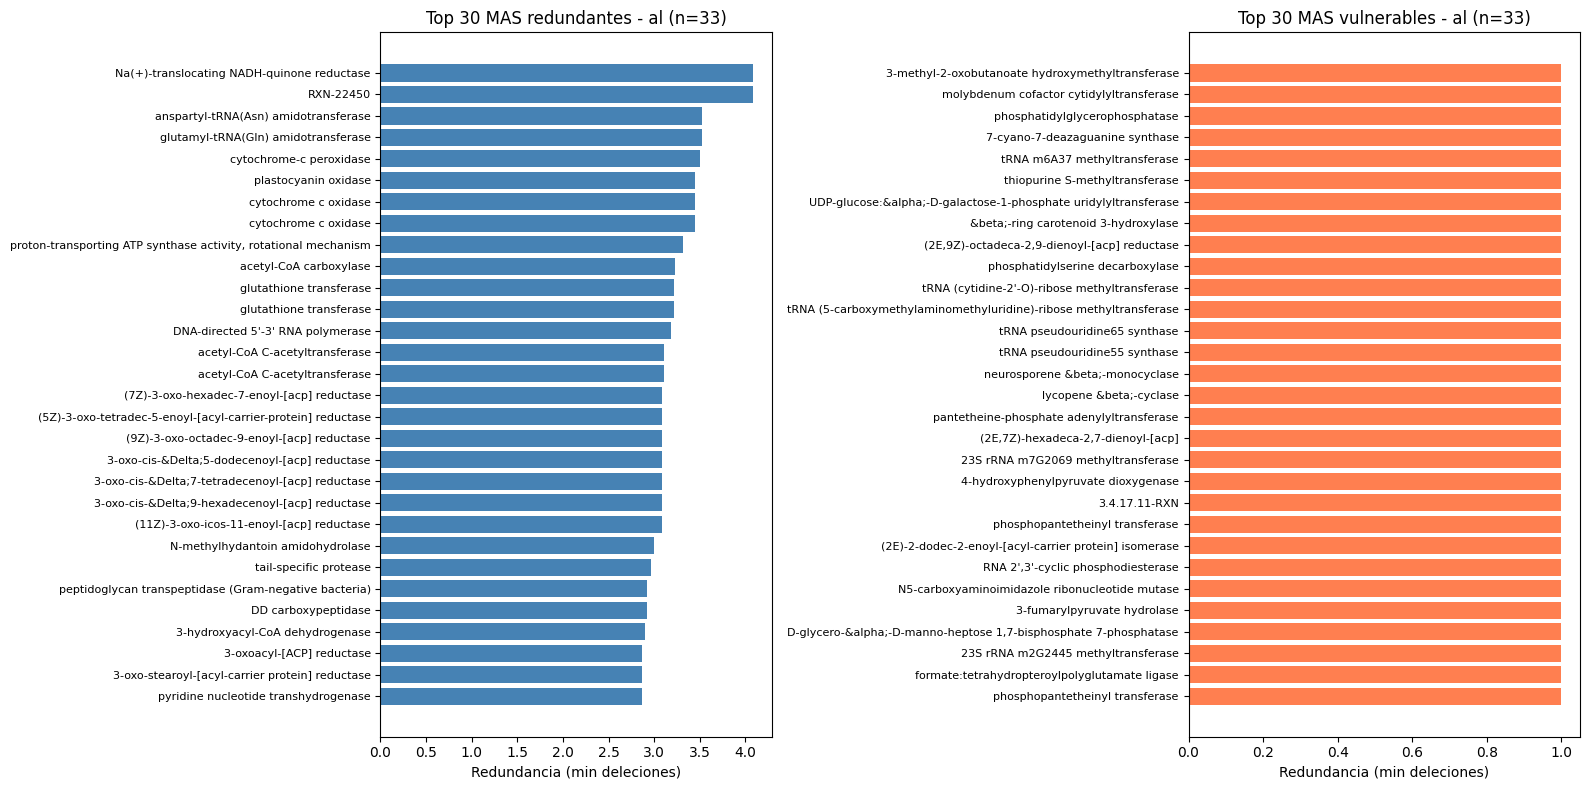

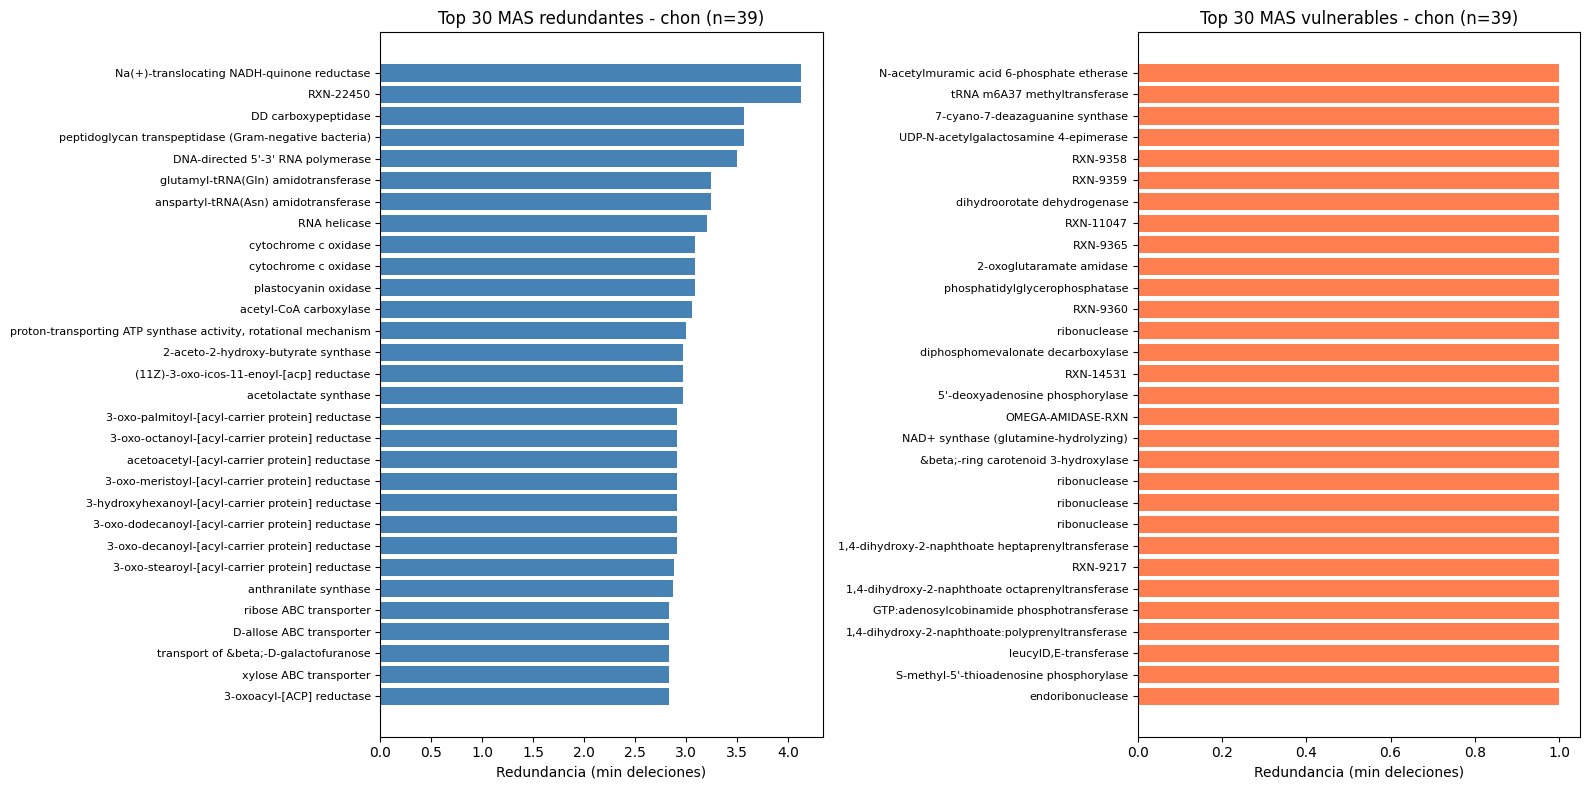

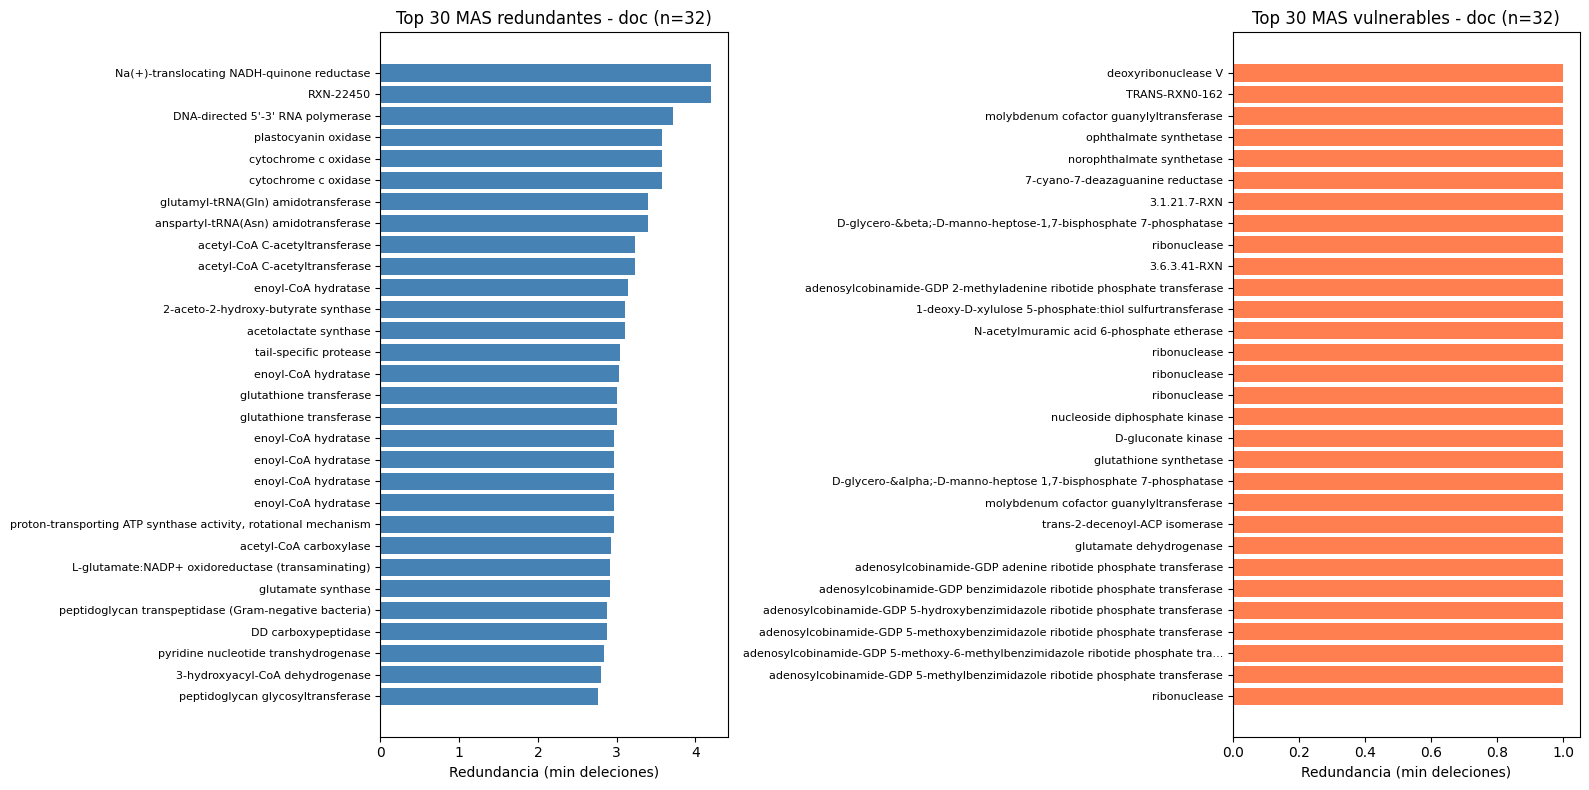

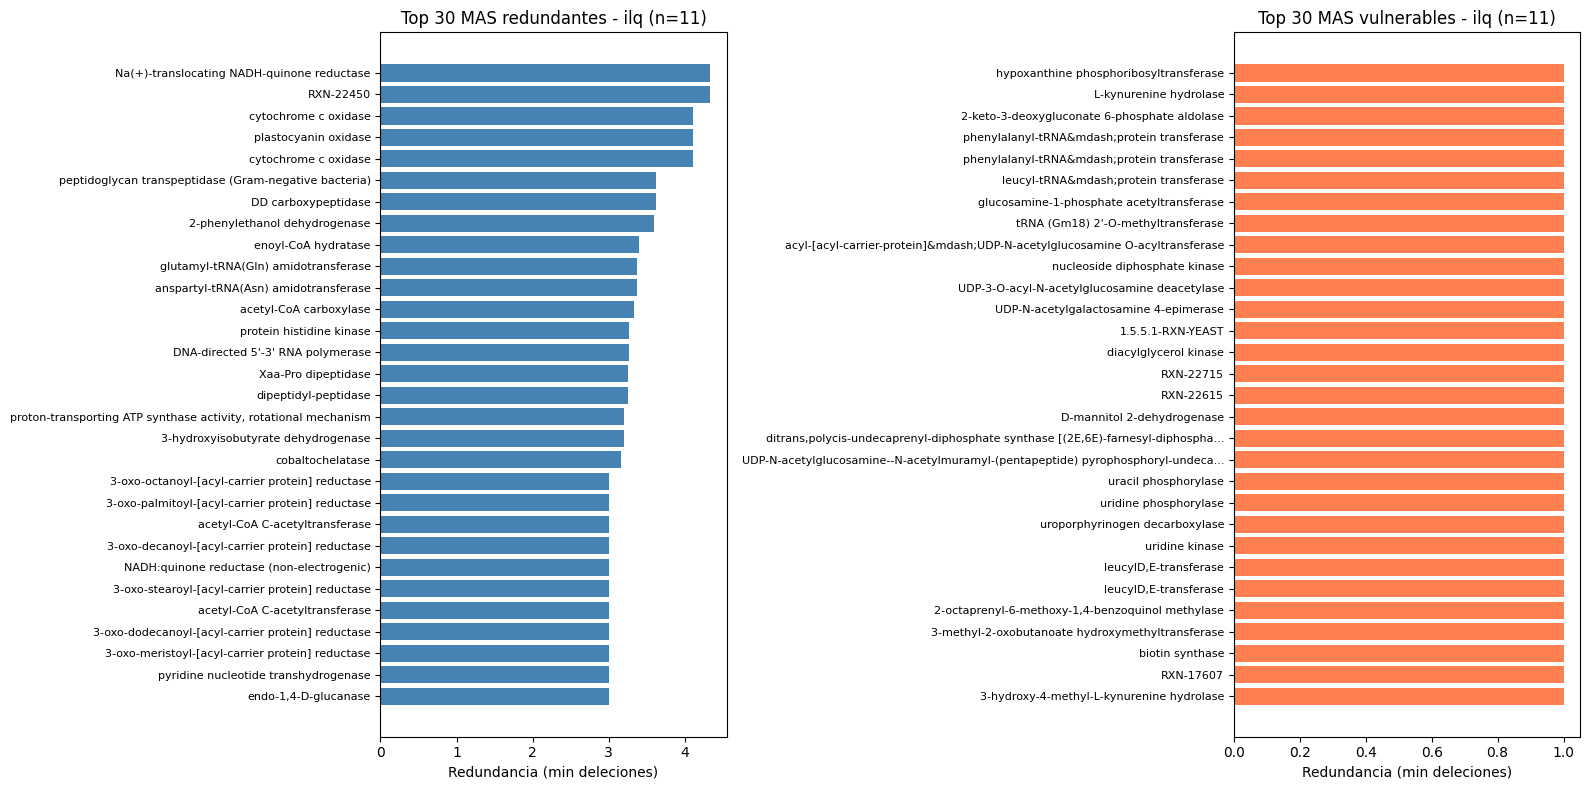

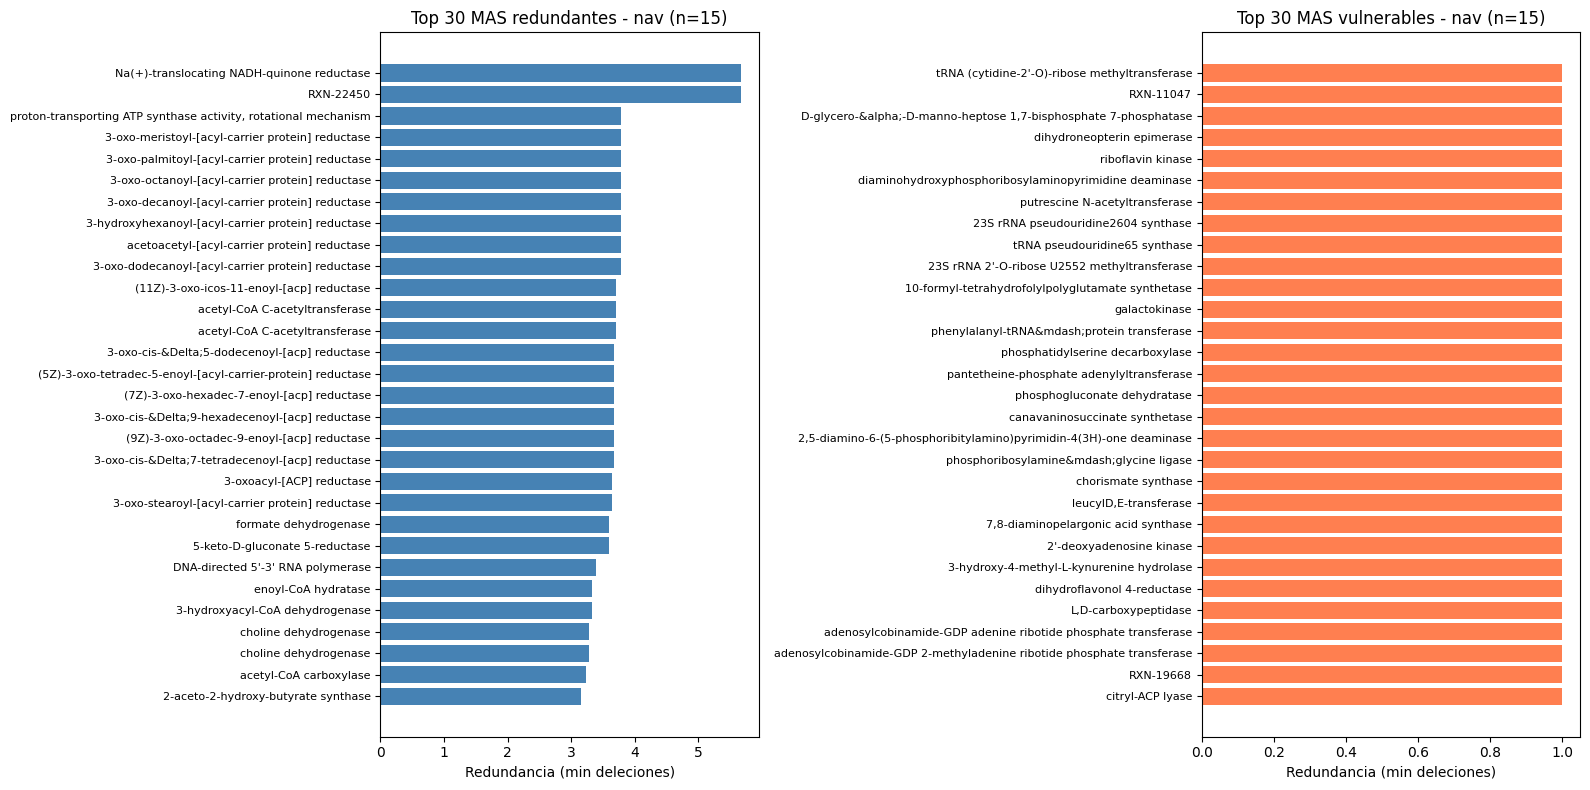

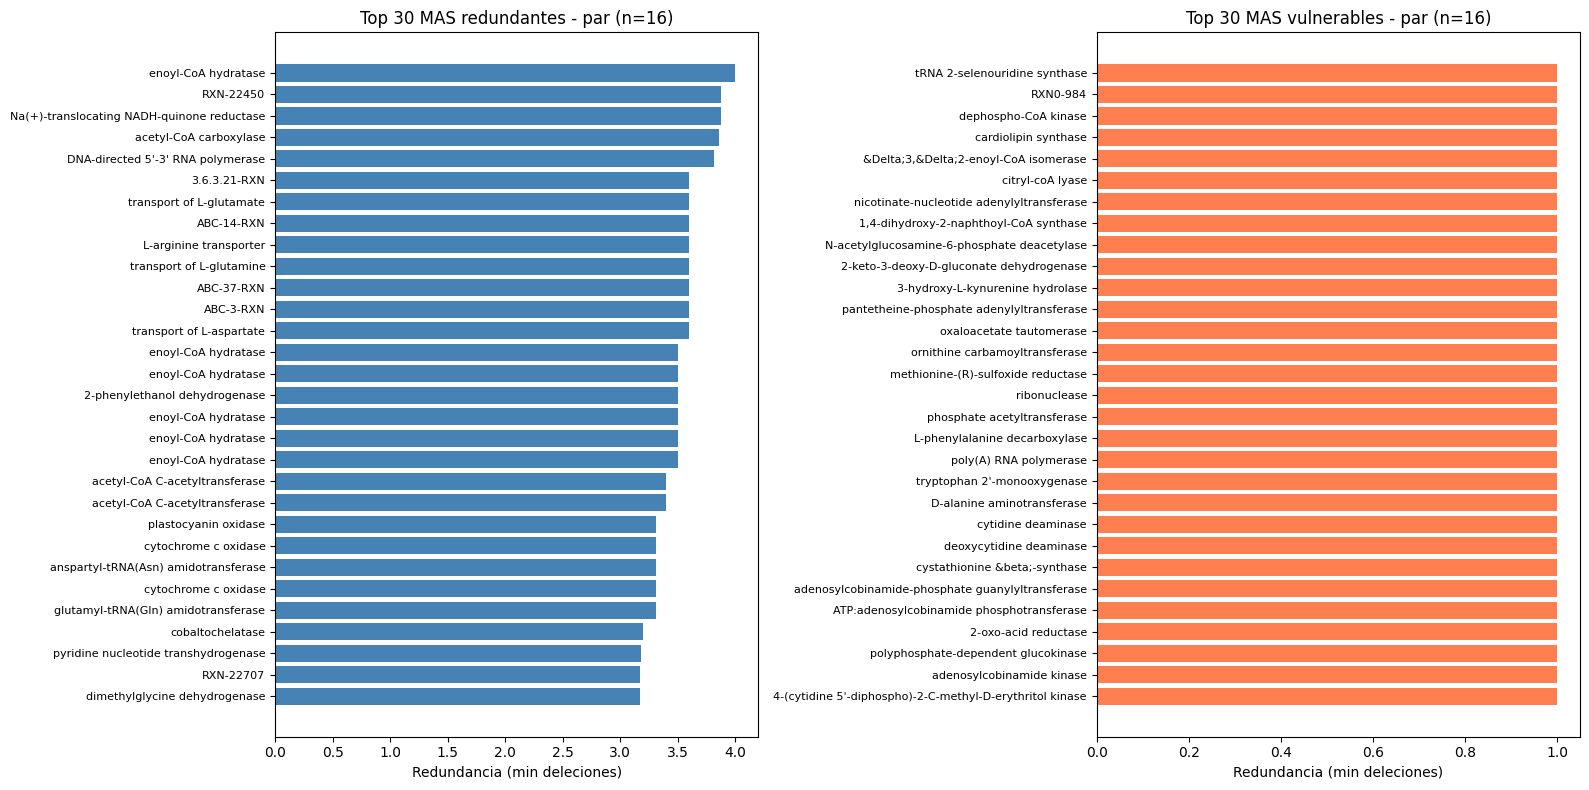

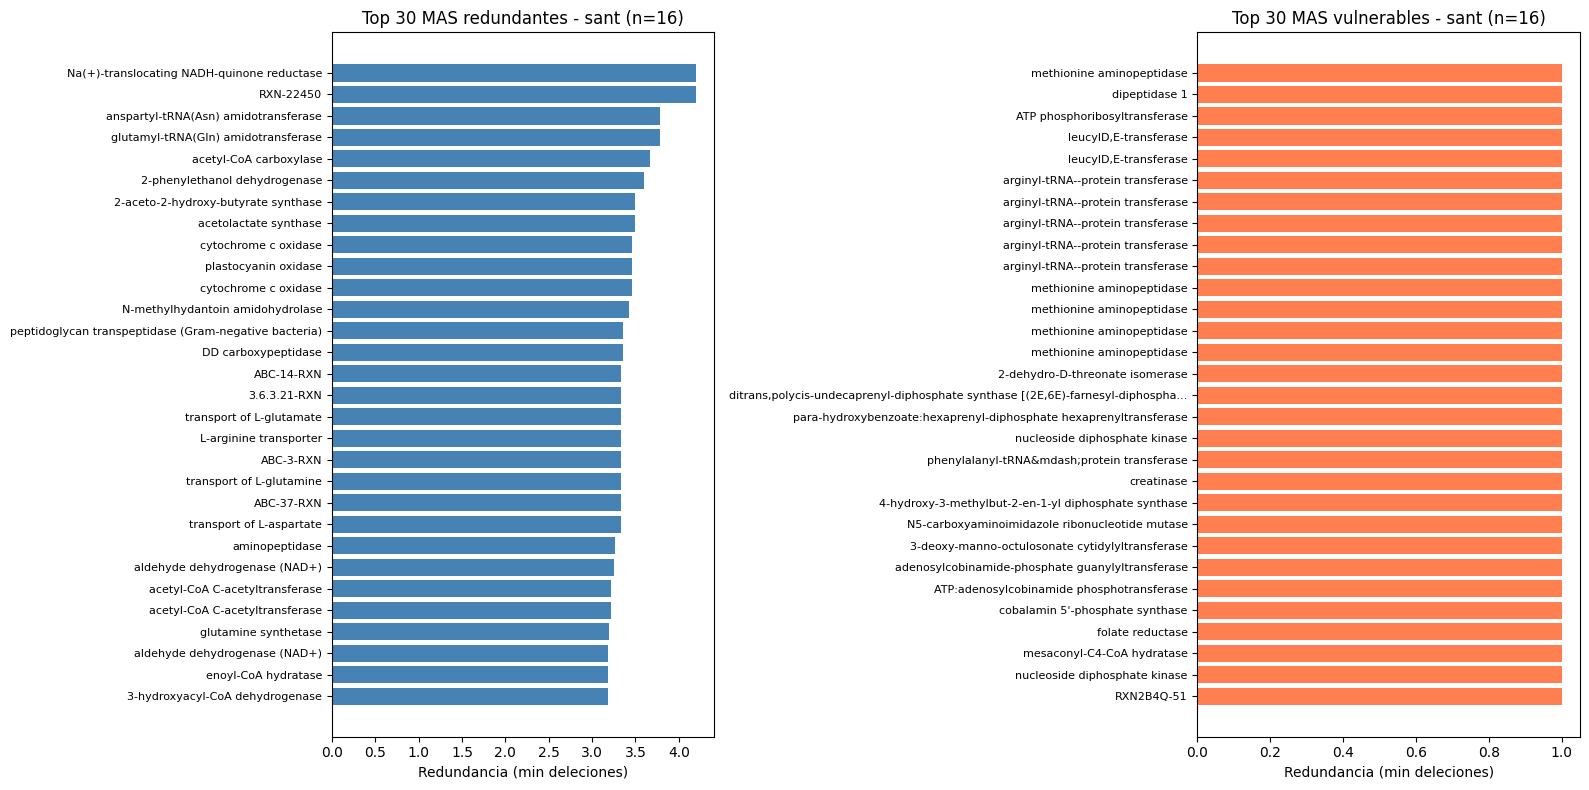

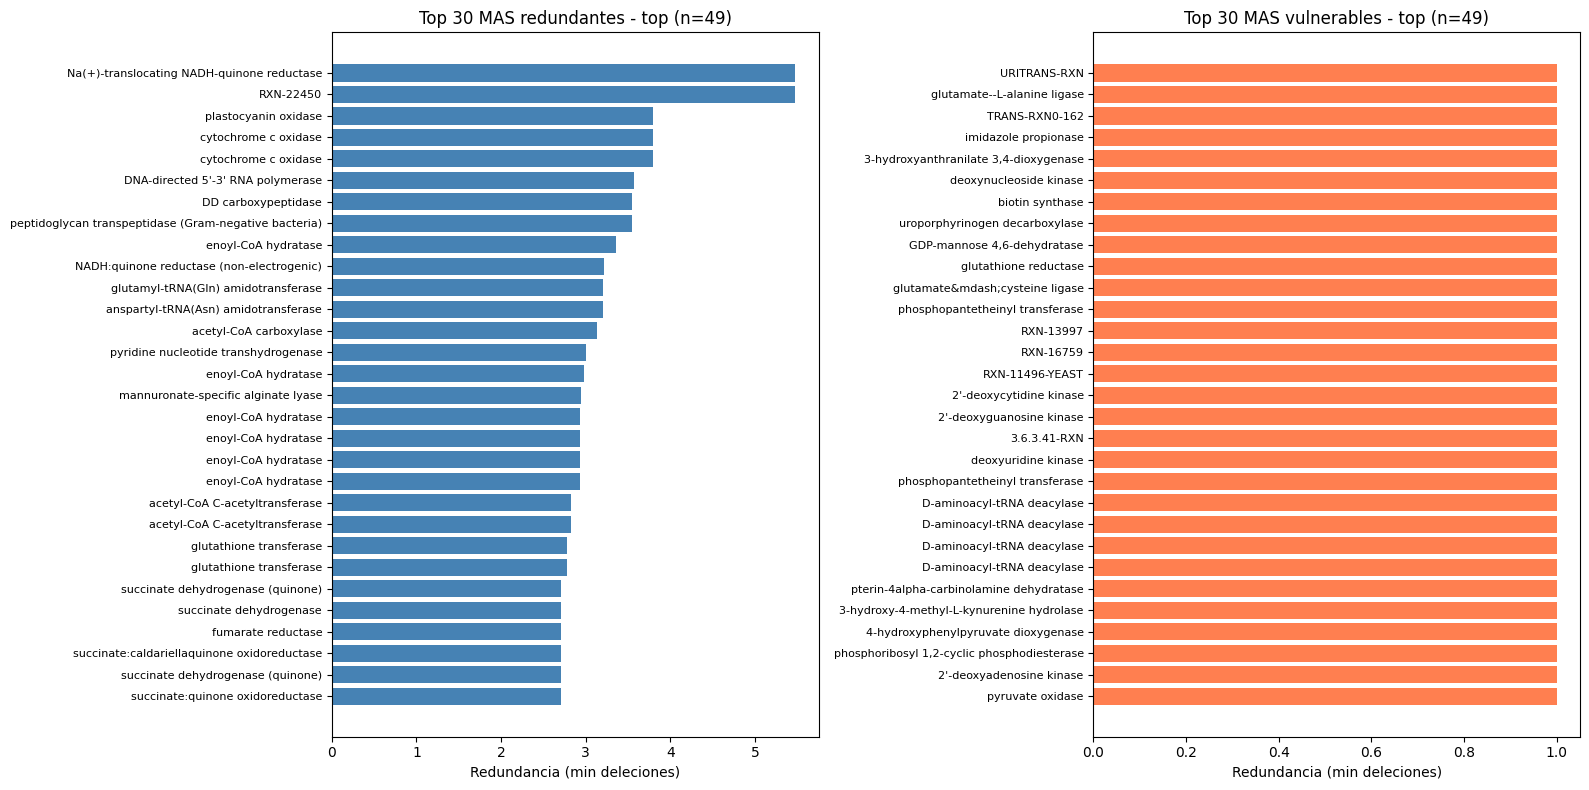


RESUMEN FINAL

Archivos generados en: /content/drive/MyDrive/MASH_primavera_2025/out/run_20251225_182334/analisis_20251226_160433

CSVs principales:
  - reacciones_con_genes.csv (231,292 filas)
  - reacciones_sin_genes.csv (0 filas)
  - universales.csv (616 reacciones)
  - raras.csv (2,660 reacciones)
  - unicas.csv (528 reacciones)
  - top30_redundantes.csv
  - top30_vulnerables.csv
  - conservadas_{sitio}.csv (8 archivos)
  - redundancia_{sitio}.csv (8 archivos)
  - matriz_binaria.csv
  - resumen_subsistemas.csv

Graficos:
  - graficos_globales.png
  - subsistemas_top20.png
  - conservadas_{sitio}.png (8 archivos)
  - redundancia_{sitio}.png (8 archivos)


In [6]:
# Conectar al Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd # manipular tablas
import matplotlib.pyplot as plt # graficos
import re # expresiones regulares (IDs y nombres)
import os
import datetime

# CONFIGURACION DE RUTAS
MASTER_PATH = "/content/drive/MyDrive/MASH_primavera_2025/out/run_20251225_182334/reacciones_completo.csv" # CSV
PADMET_PATH = "/content/drive/MyDrive/MASH_primavera_2025/out/metacyc/metacyc26.padmet" # MetaCyc
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR = f"/content/drive/MyDrive/MASH_primavera_2025/out/run_20251225_182334/analisis_{timestamp}"
os.makedirs(OUT_DIR, exist_ok=True) # Salida


# Leer CSV
df = pd.read_csv(
    MASTER_PATH,
    sep=',',
    encoding='latin-1',
    quotechar='"',
    quoting=0,
    on_bad_lines='warn',
    engine='python'
)

# CSV inicial (sin filtracion de rxns)
filas_iniciales = len(df)
modelos_iniciales = df['modelo_id'].nunique()
rxns_iniciales = df['rxn_id'].nunique() # rxns unicas

print(f"\nDatos cargados:")
print(f"  Filas totales: {filas_iniciales:,}")
print(f"  Modelos unicos: {modelos_iniciales}")
print(f"  Reacciones unicas: {rxns_iniciales:,}")
print(f"  Sitios: {df['sitio'].nunique()}")

# Definir reacciones sin gpr
df['min_deleciones_gpr'] = pd.to_numeric(
    df['min_deleciones_gpr'].astype(str).str.split(';').str[0],
    errors='coerce'
)

df_con_genes = df[df['min_deleciones_gpr'].notna()].copy() # juntar rxn con gpr
df_sin_genes = df[df['min_deleciones_gpr'].isna()].copy() # juntar rxns sin gpr

print(f"\nReacciones CON genes (GPR): {len(df_con_genes):,} ({len(df_con_genes)/len(df)*100:.1f}%)")
print(f"Reacciones SIN genes: {len(df_sin_genes):,} ({len(df_sin_genes)/len(df)*100:.1f}%)")

df_con_genes.to_csv(f"{OUT_DIR}/reacciones_con_genes.csv", index=False)
df_sin_genes.to_csv(f"{OUT_DIR}/reacciones_sin_genes.csv", index=False)

# ESTADISTICAS POR SITIO (funciones groupby y nunique)

# Cuantos modelos x sitio
print("\nModelos por sitio:")
for sitio, n in df.groupby('sitio')['modelo_id'].nunique().items():
    print(f"  {sitio}: {n} modelos")

# Rxns unicas x sitio
print("\nReacciones unicas por sitio:")
for sitio, n in df.groupby('sitio')['rxn_id'].nunique().items():
    print(f"  {sitio}: {n:,} reacciones")

# CARGA DE NOMBRES DESDE PADMET Y CSV
print("\n" + "="*80)
print("CARGA DE NOMBRES DESDE PADMET Y CSV")
print("="*80)

# Aqui se usa el archivo PADMET del inicio
# Traducir de PWY a nombre común (subsistemas)
def cargar_nombres_subsistemas_padmet(padmet_path):
    subsystem_dict = {}
    try:
        with open(padmet_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()

        # PATRON 1: Buscar (PWY-XXXX "nombre")
        pattern1 = r'\(([A-Z0-9-]*PWY[0-9A-Z-]*)\s+"([^"]+)"\)'
        for match in re.finditer(pattern1, content):
            pwy_id = match.group(1)
            nombre = match.group(2).strip()
            if len(nombre) > 2 and pwy_id not in subsystem_dict:
                subsystem_dict[pwy_id] = nombre

        # PATRON 2: Buscar pathway PWY-XXXX seguido de COMMON-NAME en líneas siguientes
        lines = content.split('\n')
        for i, line in enumerate(lines):
            # Buscar líneas que contienen "pathway" y un PWY
            if 'pathway' in line.lower() or 'PWY' in line:
                pwy_match = re.search(r'(PWY[0-9A-Z-]+)', line)
                if pwy_match:
                    pwy_id = pwy_match.group(1)
                    if pwy_id in subsystem_dict:
                        continue
                    # Buscar COMMON-NAME en las siguientes 10 líneas
                    for j in range(1, 11):
                        if i+j < len(lines):
                            next_line = lines[i+j]
                            if 'COMMON-NAME' in next_line:
                                # Extraer el nombre después de COMMON-NAME
                                name_match = re.search(r'COMMON-NAME\s+(.+?)(?:\s+TAXONOMIC|\s+INPUT|\s+OUTPUT|\s+TYPES|\s*$)', next_line)
                                if name_match:
                                    nombre = name_match.group(1).strip().strip('"').strip("'")
                                    # Limpiar caracteres extraños
                                    nombre = re.sub(r'\s+', ' ', nombre)
                                    if len(nombre) > 2:
                                        subsystem_dict[pwy_id] = nombre
                                break

        # PATRON 3: Búsqueda más agresiva - cualquier PWY seguido de texto entre comillas
        pattern3 = r'(PWY[0-9A-Z-]+)[^\n]*"([^"]{10,})"'
        for match in re.finditer(pattern3, content):
            pwy_id = match.group(1)
            nombre = match.group(2).strip()
            if len(nombre) > 2 and pwy_id not in subsystem_dict:
                # Verificar que no sea un compuesto o algo raro
                if not any(x in nombre.upper() for x in ['UNIQUE-ID', 'TYPES', 'SYNONYMS', 'DBLINKS']):
                    subsystem_dict[pwy_id] = nombre

        print(f"\nSubsistemas cargados desde PADMET: {len(subsystem_dict)}")

        # DIAGNÓSTICO: Mostrar algunos ejemplos cargados
        print("\nEjemplos de subsistemas cargados:")
        for i, (pwy_id, nombre) in enumerate(list(subsystem_dict.items())[:5]):
            print(f"  {pwy_id:20s} -> {nombre[:60]}...")

    except Exception as e:
        print(f"Error al cargar PADMET: {e}")
        import traceback
        traceback.print_exc()

    return subsystem_dict

subsystem_dict = cargar_nombres_subsistemas_padmet(PADMET_PATH)

# DIAGNÓSTICO: Ver qué PWYs del CSV NO están en el diccionario
print("\n" + "="*80)
print("DIAGNOSTICO: PWYs faltantes")
print("="*80)

pwys_en_csv = set(df['subsystem'].dropna().unique())
pwys_en_dict = set(subsystem_dict.keys())

# Extraer todos los PWYs individuales (considerando que puede haber múltiples separados por coma)
pwys_individuales = set()
for pwy in pwys_en_csv:
    pwy_str = str(pwy).strip()
    if ',' in pwy_str:
        pwys_individuales.update([p.strip() for p in pwy_str.split(',')])
    else:
        pwys_individuales.add(pwy_str)

pwys_faltantes = pwys_individuales - pwys_en_dict
print(f"\nPWYs en CSV: {len(pwys_individuales)}")
print(f"PWYs en PADMET: {len(pwys_en_dict)}")
print(f"PWYs FALTANTES en PADMET: {len(pwys_faltantes)}")

if len(pwys_faltantes) > 0:
    print(f"\nPrimeros 20 PWYs faltantes:")
    for pwy in sorted(list(pwys_faltantes))[:20]:
        print(f"  {pwy}")

nombre_dict = df[['rxn_id', 'rxn_nombre']].drop_duplicates().set_index('rxn_id')['rxn_nombre'].to_dict()

def traducir_rxn(rxn_id):
    nombre = nombre_dict.get(rxn_id, rxn_id)
    if len(str(nombre)) > 80:
        nombre = str(nombre)[:77] + "..."
    return nombre

def traducir_subsistema(subsys_id):
    if pd.isna(subsys_id):
        return "Sin subsistema"

    subsys_id = str(subsys_id).strip()

    # Si hay múltiples PWYs separados por comas, intentar traducir el primero
    if ',' in subsys_id:
        pwy_principal = subsys_id.split(',')[0].strip()
        nombre = subsystem_dict.get(pwy_principal, None)
        if nombre and len(str(nombre)) > 2:
            if len(str(nombre)) > 80:
                nombre = str(nombre)[:77] + "..."
            return nombre
        # Si no se encontró, devolver el ID completo
        return subsys_id

    # Buscar en el diccionario
    nombre = subsystem_dict.get(subsys_id, subsys_id)

    if len(str(nombre)) > 80:
        nombre = str(nombre)[:77] + "..."

    return nombre

# EJEMPLOS DE TRADUCCION (10 REACCIONES)
print("\n" + "="*80)
print("EJEMPLOS DE TRADUCCION: REACCIONES (10 primeras)")
print("="*80)

ejemplos_rxn = df[['rxn_id', 'rxn_nombre']].drop_duplicates().head(10)
print("\nID original -> Nombre traducido")
print("-" * 80)
for idx, row in ejemplos_rxn.iterrows():
    print(f"{row['rxn_id']:30s} -> {traducir_rxn(row['rxn_id'])}")

# EJEMPLOS DE TRADUCCION (20 SUBSISTEMAS) - Aumentado para ver más ejemplos
print("\n" + "="*80)
print("EJEMPLOS DE TRADUCCION: SUBSISTEMAS (20 primeros)")
print("="*80)

ejemplos_subsys = df[['subsystem']].dropna().drop_duplicates().head(20)
print("\nID original -> Nombre traducido")
print("-" * 80)
for idx, row in ejemplos_subsys.iterrows():
    subsys_id = row['subsystem']
    traducido = traducir_subsistema(subsys_id)
    print(f"{subsys_id:40s} -> {traducido}")

# ANALISIS DE UNIVERSALIDAD

rxn_freq = df.groupby('rxn_id')['modelo_id'].nunique().reset_index()
rxn_freq.columns = ['rxn_id', 'n_modelos']
rxn_freq['prop'] = (rxn_freq['n_modelos'] / df['modelo_id'].nunique()) * 100
rxn_freq['categoria'] = 'Intermedia'
rxn_freq.loc[rxn_freq['prop'] >= 70, 'categoria'] = 'Universal' # Rxn aparece en al menos 70% modelos de los 211 (VARIABLE)
rxn_freq.loc[rxn_freq['prop'] <= 20, 'categoria'] = 'Rara' # Rxn aparece en menos del 20% de modelos totales (VARIABLE)

universales = rxn_freq[rxn_freq['categoria'] == 'Universal'].sort_values('n_modelos', ascending=False)
raras = rxn_freq[rxn_freq['categoria'] == 'Rara'].sort_values('n_modelos')
unicas = rxn_freq[rxn_freq['n_modelos'] == 1].copy()

print(f"\nReacciones universales (>=70% modelos): {len(universales):,}") # PUEDE CAMBIAR
print(f"Reacciones raras (<=20% modelos): {len(raras):,}") # PUEDE CAMBIAR
print(f"Reacciones unicas (1 modelo): {len(unicas):,}") # Aparecen solo en uno de los modelos (altamente especifica, dentro de las raras)

# ANALISIS DE REDUNDANCIA (SOLO CON GENES)
print("\n" + "="*80)
print("ANALISIS DE REDUNDANCIA (solo reacciones con GPR)")
print("="*80)

rxn_red = df_con_genes.groupby('rxn_id')['min_deleciones_gpr'].mean().reset_index()
rxn_red.columns = ['rxn_id', 'redundancia']
rxn_red = rxn_red.merge(rxn_freq[['rxn_id', 'n_modelos']], on='rxn_id')

redundantes = rxn_red.sort_values('redundancia', ascending=False).head(30)
vulnerables = rxn_red[rxn_red['n_modelos'] >= 5].sort_values('redundancia').head(30)

print(f"\nTop 30 reacciones MAS redundantes (primeras 5):")
for idx, row in redundantes.head(5).iterrows():
    print(f"  {row['rxn_id']}: redundancia={row['redundancia']:.2f}, n_modelos={row['n_modelos']}")

print(f"\nTop 30 reacciones MAS vulnerables (primeras 5):")
for idx, row in vulnerables.head(5).iterrows():
    print(f"  {row['rxn_id']}: redundancia={row['redundancia']:.2f}, n_modelos={row['n_modelos']}")

# AGREGAR NOMBRES Y SUBSISTEMAS
rxn_subsystem = {}
for _, row in df[['rxn_id', 'subsystem']].iterrows():
    rxn_id = row['rxn_id']
    subsystem = row['subsystem']
    if rxn_id not in rxn_subsystem:
        rxn_subsystem[rxn_id] = subsystem
    elif pd.isna(rxn_subsystem[rxn_id]) and pd.notna(subsystem):
        rxn_subsystem[rxn_id] = subsystem

universales['rxn_nombre'] = universales['rxn_id'].apply(traducir_rxn)
universales['subsystem'] = universales['rxn_id'].map(rxn_subsystem)
universales['subsystem_nombre'] = universales['subsystem'].apply(traducir_subsistema)

raras['rxn_nombre'] = raras['rxn_id'].apply(traducir_rxn)
raras['subsystem'] = raras['rxn_id'].map(rxn_subsystem)
raras['subsystem_nombre'] = raras['subsystem'].apply(traducir_subsistema)

unicas['rxn_nombre'] = unicas['rxn_id'].apply(traducir_rxn)
unicas['subsystem'] = unicas['rxn_id'].map(rxn_subsystem)
unicas['subsystem_nombre'] = unicas['subsystem'].apply(traducir_subsistema)

redundantes['rxn_nombre'] = redundantes['rxn_id'].apply(traducir_rxn)
redundantes['subsystem'] = redundantes['rxn_id'].map(rxn_subsystem)
redundantes['subsystem_nombre'] = redundantes['subsystem'].apply(traducir_subsistema)

vulnerables['rxn_nombre'] = vulnerables['rxn_id'].apply(traducir_rxn)
vulnerables['subsystem'] = vulnerables['rxn_id'].map(rxn_subsystem)
vulnerables['subsystem_nombre'] = vulnerables['subsystem'].apply(traducir_subsistema)

# GUARDAR CSVS PRINCIPALES
universales.to_csv(f"{OUT_DIR}/universales.csv", index=False)
raras.to_csv(f"{OUT_DIR}/raras.csv", index=False)
unicas.to_csv(f"{OUT_DIR}/unicas.csv", index=False)
redundantes.to_csv(f"{OUT_DIR}/top30_redundantes.csv", index=False)
vulnerables.to_csv(f"{OUT_DIR}/top30_vulnerables.csv", index=False)

# ANALISIS POR SITIO: CONSERVADAS
print("\n" + "="*80)
print("ANALISIS POR SITIO: REACCIONES CONSERVADAS (>=70%)")
print("="*80)

for sitio in sorted(df['sitio'].unique()):
    df_sitio = df[df['sitio'] == sitio]
    n_modelos = df_sitio['modelo_id'].nunique()

    rxn_sitio = df_sitio.groupby('rxn_id')['modelo_id'].nunique().reset_index()
    rxn_sitio.columns = ['rxn_id', 'n_modelos_sitio']
    rxn_sitio['prop'] = (rxn_sitio['n_modelos_sitio'] / n_modelos) * 100

    conservadas = rxn_sitio[rxn_sitio['prop'] >= 70].sort_values('prop', ascending=False)
    conservadas['rxn_nombre'] = conservadas['rxn_id'].apply(traducir_rxn)
    conservadas['subsystem'] = conservadas['rxn_id'].map(rxn_subsystem)
    conservadas['subsystem_nombre'] = conservadas['subsystem'].apply(traducir_subsistema)

    conservadas.to_csv(f"{OUT_DIR}/conservadas_{sitio}.csv", index=False)
    print(f"  {sitio}: {len(conservadas)} reacciones conservadas (n={n_modelos} modelos)")

# ANALISIS POR SITIO: REDUNDANCIA
print("\n" + "="*80)
print("ANALISIS POR SITIO: REDUNDANCIA")
print("="*80)

for sitio in sorted(df['sitio'].unique()):
    df_sitio = df_con_genes[df_con_genes['sitio'] == sitio]
    n_modelos = df_sitio['modelo_id'].nunique()

    rxn_red_sitio = df_sitio.groupby('rxn_id').agg({
        'min_deleciones_gpr': 'mean',
        'modelo_id': 'nunique'
    }).reset_index()
    rxn_red_sitio.columns = ['rxn_id', 'redundancia', 'n_modelos_sitio']
    rxn_red_sitio['prop'] = (rxn_red_sitio['n_modelos_sitio'] / n_modelos) * 100
    rxn_red_sitio = rxn_red_sitio[rxn_red_sitio['prop'] >= 30]

    rxn_red_sitio['rxn_nombre'] = rxn_red_sitio['rxn_id'].apply(traducir_rxn)
    rxn_red_sitio['subsystem'] = rxn_red_sitio['rxn_id'].map(rxn_subsystem)
    rxn_red_sitio['subsystem_nombre'] = rxn_red_sitio['subsystem'].apply(traducir_subsistema)

    rxn_red_sitio.to_csv(f"{OUT_DIR}/redundancia_{sitio}.csv", index=False)
    print(f"  {sitio}: {len(rxn_red_sitio)} reacciones analizadas (n={n_modelos} modelos)")

# MATRIZ BINARIA
print("\n" + "="*80)
print("GENERACION DE MATRIZ BINARIA")
print("="*80)

matriz = df.assign(presente=1).pivot_table(
    index='modelo_id',
    columns='rxn_id',
    values='presente',
    fill_value=0
)

modelo_sitio = df[['modelo_id', 'sitio']].drop_duplicates().set_index('modelo_id')
matriz_con_sitio = matriz.merge(modelo_sitio, left_index=True, right_index=True)
cols = ['sitio'] + [c for c in matriz_con_sitio.columns if c != 'sitio']
matriz_con_sitio = matriz_con_sitio[cols]

matriz_con_sitio.to_csv(f"{OUT_DIR}/matriz_binaria.csv")
print(f"\nMatriz binaria: {matriz.shape[0]} modelos x {matriz.shape[1]} reacciones")

# ANALISIS DE SUBSISTEMAS
print("\n" + "="*80)
print("ANALISIS DE SUBSISTEMAS")
print("="*80)

subsystem_stats = []
for subsys in df['subsystem'].dropna().unique():
    df_subsys = df[df['subsystem'] == subsys]
    n_rxns = df_subsys['rxn_id'].nunique()
    n_modelos = df_subsys['modelo_id'].nunique()
    prop_modelos = (n_modelos / df['modelo_id'].nunique()) * 100
    redundancia_avg = df_subsys[df_subsys['min_deleciones_gpr'].notna()].groupby('rxn_id')['min_deleciones_gpr'].mean().mean()

    subsystem_stats.append({
        'subsystem': subsys,
        'subsystem_nombre': traducir_subsistema(subsys),
        'n_reacciones': n_rxns,
        'n_modelos': n_modelos,
        'prop_modelos': prop_modelos,
        'redundancia_promedio': redundancia_avg
    })

df_subsys_summary = pd.DataFrame(subsystem_stats).sort_values('n_reacciones', ascending=False)
df_subsys_summary.to_csv(f"{OUT_DIR}/resumen_subsistemas.csv", index=False)

print(f"\nTop 10 subsistemas con mas reacciones:")
for idx, row in df_subsys_summary.head(10).iterrows():
    print(f"  {row['subsystem']:30s} -> {row['n_reacciones']:3.0f} rxns, {row['prop_modelos']:5.1f}% modelos")

# GRAFICOS GLOBALES
print("\n" + "="*80)
print("GENERACION DE GRAFICOS")
print("="*80)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

top30_univ = universales.head(30)
ax1.barh(range(len(top30_univ)), top30_univ['prop'], color='darkgreen')
ax1.set_yticks(range(len(top30_univ)))
ax1.set_yticklabels(top30_univ['rxn_nombre'], fontsize=7)
ax1.set_xlabel('% modelos')
ax1.set_title('Top 30 Universales (>=70%)')
ax1.invert_yaxis()

top30_raras = raras.head(30)
ax2.barh(range(len(top30_raras)), top30_raras['prop'], color='darkred')
ax2.set_yticks(range(len(top30_raras)))
ax2.set_yticklabels(top30_raras['rxn_nombre'], fontsize=7)
ax2.set_xlabel('% modelos')
ax2.set_title('Top 30 Raras (<=20%)')
ax2.invert_yaxis()

top30_red = redundantes.head(30)
ax3.barh(range(len(top30_red)), top30_red['redundancia'], color='steelblue')
ax3.set_yticks(range(len(top30_red)))
ax3.set_yticklabels(top30_red['rxn_nombre'], fontsize=7)
ax3.set_xlabel('Redundancia (min deleciones)')
ax3.set_title('Top 30 MAS Redundantes')
ax3.invert_yaxis()

top30_vul = vulnerables.head(30)
ax4.barh(range(len(top30_vul)), top30_vul['redundancia'], color='coral')
ax4.set_yticks(range(len(top30_vul)))
ax4.set_yticklabels(top30_vul['rxn_nombre'], fontsize=7)
ax4.set_xlabel('Redundancia (min deleciones)')
ax4.set_title('Top 30 MAS Vulnerables (>=5 modelos)')
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/graficos_globales.png", dpi=300, bbox_inches='tight')
plt.show()

# GRAFICOS DE SUBSISTEMAS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

top20_subsys = df_subsys_summary.head(20)

ax1.barh(range(len(top20_subsys)), top20_subsys['n_reacciones'], color='teal')
ax1.set_yticks(range(len(top20_subsys)))
ax1.set_yticklabels(top20_subsys['subsystem_nombre'], fontsize=9)
ax1.set_xlabel('Numero de reacciones unicas')
ax1.set_title('Top 20 Subsistemas: Reacciones')
ax1.invert_yaxis()

ax2.barh(range(len(top20_subsys)), top20_subsys['redundancia_promedio'], color='coral')
ax2.set_yticks(range(len(top20_subsys)))
ax2.set_yticklabels(top20_subsys['subsystem_nombre'], fontsize=9)
ax2.set_xlabel('Redundancia promedio')
ax2.set_title('Top 20 Subsistemas: Redundancia')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/subsistemas_top20.png", dpi=300, bbox_inches='tight')
plt.show()

# GRAFICOS POR SITIO
for sitio in sorted(df['sitio'].unique()):
    df_sitio = df[df['sitio'] == sitio]
    n_modelos = df_sitio['modelo_id'].nunique()

    rxn_sitio = df_sitio.groupby('rxn_id')['modelo_id'].nunique().reset_index()
    rxn_sitio.columns = ['rxn_id', 'n_modelos_sitio']
    rxn_sitio['prop'] = (rxn_sitio['n_modelos_sitio'] / n_modelos) * 100
    top30 = rxn_sitio[rxn_sitio['prop'] >= 70].sort_values('prop', ascending=False).head(30)

    if len(top30) > 0:
        top30['rxn_nombre'] = top30['rxn_id'].apply(traducir_rxn)
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top30)), top30['prop'], color='teal')
        plt.yticks(range(len(top30)), top30['rxn_nombre'], fontsize=8)
        plt.xlabel('% modelos')
        plt.title(f'Top 30 conservadas (>=70%) - {sitio} (n={n_modelos})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"{OUT_DIR}/conservadas_{sitio}.png", dpi=300, bbox_inches='tight')
        plt.show()

for sitio in sorted(df['sitio'].unique()):
    df_sitio = df_con_genes[df_con_genes['sitio'] == sitio]
    n_modelos = df_sitio['modelo_id'].nunique()

    rxn_red_sitio = df_sitio.groupby('rxn_id').agg({
        'min_deleciones_gpr': 'mean',
        'modelo_id': 'nunique'
    }).reset_index()
    rxn_red_sitio.columns = ['rxn_id', 'redundancia', 'n_modelos_sitio']
    rxn_red_sitio['prop'] = (rxn_red_sitio['n_modelos_sitio'] / n_modelos) * 100
    rxn_red_sitio = rxn_red_sitio[rxn_red_sitio['prop'] >= 30]

    if len(rxn_red_sitio) == 0:
        continue

    top30_red_sitio = rxn_red_sitio.sort_values('redundancia', ascending=False).head(30)
    top30_vul_sitio = rxn_red_sitio.sort_values('redundancia', ascending=True).head(30)

    top30_red_sitio['rxn_nombre'] = top30_red_sitio['rxn_id'].apply(traducir_rxn)
    top30_vul_sitio['rxn_nombre'] = top30_vul_sitio['rxn_id'].apply(traducir_rxn)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.barh(range(len(top30_red_sitio)), top30_red_sitio['redundancia'], color='steelblue')
    ax1.set_yticks(range(len(top30_red_sitio)))
    ax1.set_yticklabels(top30_red_sitio['rxn_nombre'], fontsize=8)
    ax1.set_xlabel('Redundancia (min deleciones)')
    ax1.set_title(f'Top 30 MAS redundantes - {sitio} (n={n_modelos})')
    ax1.invert_yaxis()

    ax2.barh(range(len(top30_vul_sitio)), top30_vul_sitio['redundancia'], color='coral')
    ax2.set_yticks(range(len(top30_vul_sitio)))
    ax2.set_yticklabels(top30_vul_sitio['rxn_nombre'], fontsize=8)
    ax2.set_xlabel('Redundancia (min deleciones)')
    ax2.set_title(f'Top 30 MAS vulnerables - {sitio} (n={n_modelos})')
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/redundancia_{sitio}.png", dpi=300, bbox_inches='tight')
    plt.show()

# RESUMEN FINAL
print("\nRESUMEN FINAL")

print(f"\nArchivos generados en: {OUT_DIR}")
print(f"\nCSVs principales:")
print(f"  - reacciones_con_genes.csv ({len(df_con_genes):,} filas)")
print(f"  - reacciones_sin_genes.csv ({len(df_sin_genes):,} filas)")
print(f"  - universales.csv ({len(universales):,} reacciones)")
print(f"  - raras.csv ({len(raras):,} reacciones)")
print(f"  - unicas.csv ({len(unicas):,} reacciones)")
print(f"  - top30_redundantes.csv")
print(f"  - top30_vulnerables.csv")
print(f"  - conservadas_{{sitio}}.csv ({len(df['sitio'].unique())} archivos)")
print(f"  - redundancia_{{sitio}}.csv ({len(df['sitio'].unique())} archivos)")
print(f"  - matriz_binaria.csv")
print(f"  - resumen_subsistemas.csv")

print(f"\nGraficos:")
print(f"  - graficos_globales.png")
print(f"  - subsistemas_top20.png")
print(f"  - conservadas_{{sitio}}.png ({len(df['sitio'].unique())} archivos)")
print(f"  - redundancia_{{sitio}}.png ({len(df['sitio'].unique())} archivos)")